In [126]:
import matplotlib.pyplot as plt
import pandas as pd
import pandasql as ps
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())
from datetime import date, time, datetime
import math
import scipy.stats

In [127]:
###################################
### Processing the data ###
###################################
# Data includes monthly counts of CLABSI, non-CLABSI and secondary BSI's for each hospital and ward. 
# Data comes from two different periods:2012-2015 and 2016-2019
# Data from 2016-2019 includes information of the body site from which each secondary BSI's originated.This 
# information was used for further classification of secondary BSI's into types in order to add secondary classes
# counts. 
# Analysis of the data will be conducted on two separate tables, one for each period.

df1 = pd.read_excel(r'BSI_in_ICU_2021\data\CLABSI_2012_2015.xlsx', sheet_name='data',encoding = "ISO-8859-1")
df_2016= pd.read_excel(r'BSI_in_ICU_2021\data\CLABSI_2016_2018.xlsx', sheet_name='2016',encoding = "ISO-8859-1")
df_2017= pd.read_excel(r'BSI_in_ICU_2021\data\CLABSI_2016_2018.xlsx', sheet_name='2017',encoding = "ISO-8859-1")
df_2018= pd.read_excel(r'BSI_in_ICU_2021\data\CLABSI_2016_2018.xlsx', sheet_name='2018',encoding = "ISO-8859-1")
df_2019= pd.read_excel(r'BSI_in_ICU_2021\data\CLABSI_2019_2.xlsx', sheet_name='Sheet1',encoding = "ISO-8859-1")
second_bacteremia_class=pd.read_excel(r'BSI_in_ICU_2021\data\second_bacteremia_class.xlsx', sheet_name='sheet1',encoding = "ISO-8859-1")
hospital_group=pd.read_excel(r'hospital_codes.xlsx', sheet_name='Sheet1',encoding = "ISO-8859-1") 
ward_type = pd.read_excel(r'CLABSI_2016_2018.xlsx', sheet_name='wards',encoding = "ISO-8859-1")

In [128]:
df_2016.columns = df_2016.columns.str.replace(' ','_')
df_2017.columns = df_2017.columns.str.replace(' ','_')
df_2018.columns = df_2018.columns.str.replace(' ','_')
df_2019.columns = df_2019.columns.str.replace(' ','_')

In [130]:
df1['year'] =  [int(x) if pd.notnull(x) else str('NaN') for x in pd.DatetimeIndex(df1['month_year']).year]
df_2016['year'] =  [int(x) if pd.notnull(x) else str('NaN') for x in pd.DatetimeIndex(df_2016['month_year']).year]
df_2017['year'] =  [int(x) if pd.notnull(x) else str('NaN') for x in pd.DatetimeIndex(df_2017['month_year']).year]
df_2018['year'] =  [int(x) if pd.notnull(x) else str('NaN') for x in pd.DatetimeIndex(df_2018['month_year']).year]
df_2019['year'] =  [int(x) if pd.notnull(x) else str('NaN') for x in pd.DatetimeIndex(df_2019['month_year']).year]
df1['month'] =  [int(x) if pd.notnull(x) else str('NaN') for x in pd.DatetimeIndex(df1['month_year']).month]
df_2016['month'] =  [int(x) if pd.notnull(x) else str('NaN') for x in pd.DatetimeIndex(df_2016['month_year']).month]
df_2017['month'] =  [int(x) if pd.notnull(x) else str('NaN') for x in pd.DatetimeIndex(df_2017['month_year']).month]
df_2018['month'] =  [int(x) if pd.notnull(x) else str('NaN') for x in pd.DatetimeIndex(df_2018['month_year']).month]
df_2019['month'] =  [int(x) if pd.notnull(x) else str('NaN') for x in pd.DatetimeIndex(df_2019['month_year']).month]

In [131]:
df_2016_2019 = pd.concat([df_2016, df_2017, df_2018,df_2019], sort=False)
print(df_2016.shape)
print(df_2017.shape)
print(df_2018.shape)
print(df_2019.shape)
print(df_2016_2019.shape)

(1464, 26)
(2636, 22)
(2804, 19)
(2793, 17)
(9697, 28)


In [133]:
# Add ward
q_addWard = """select a.*
                      ,b.New as Ward
               from df_2016_2019 a left outer join 
                    ward_type b
               on trim(a.unit_name)=trim(b.unit_type)"""
df_2016_2019_ward = pysqldf(q_addWard)

In [135]:
# Correct hospital names 
q_correct_names = """select *,
                           (case when hospital='משפחה קדושה' then 'המשפחה הקדושה' 
                            when hospital='אסף הרופא' then 'יצחק שמיר (אסה"ר)' 
                            when hospital='רמבם' then 'רמב"ם'
                            when hospital='אנגלי נצרת' then 'נצרת אנגלי'
                            when hospital='סנט וינסנט' then 'צרפתי נצרת'
                            when hospital='מרכז רפואי זיו' then 'זיו'
                            when hospital='המרכז הרפואי לגליל' then 'נהריה'
                            when hospital='מרכז רפואי ת"א' then 'איכילוב'
                            when hospital='נצרת  EMMS' then 'נצרת אנגלי' 
                            else hospital end) as hospital2
                     from df_2016_2019_ward a"""

df_2016_2019_hosp = pysqldf(q_correct_names)    

In [136]:
# Add hosp group
q_addGroup1 = """select a.*,
                       b.size
                from df1 a left outer join 
                     hospital_group b 
                on a.hospital2=b.hosp_num;"""
df1_hospGroup = pysqldf(q_addGroup1)

q_addGroup2 = """select a.*,
                       b.size,
                       b.hosp_num
                from df_2016_2019_hosp a left outer join 
                     hospital_group b 
                on trim(a.hospital2)=trim(b.hosp_name);"""
df_2016_2019_hospGroup =pysqldf(q_addGroup2)

In [ ]:
# Up to this point, the processing of the table with the data from 2012-2015 (df1) has been completed while
# the table with the data from 2016-2019 (df_2016_2019) needs to be further processed in order to classify
# secondary BSI's as described above.  

In [137]:
# Transpose df_2016_2019 table from "wide" to "long" form, such that each secondary BSI is represented by a row
# (instead of elaborating all secondary BSI's in each row)

col_names=[]
for col in df_2016_2019_hospGroup:
    col_names.append(col)
for name in ['second_bact_1','second_bact_2','second_bact_3','second_bact_4','second_bact_5','second_bact_6','second_bact_7']:
    col_names.remove(name)
col_names    
df_2016_long=df_2016_2019_hospGroup.melt(id_vars=col_names)

['unit_type',
 'unit_name',
 'Ward',
 'number_of_CLABSI',
 'line_days',
 'number_of_primary_non_CLABSI',
 'number_of_secondary_BSI',
 'number_of_MBI',
 'total_number_of_events',
 'patient_days',
 'birth_weight',
 'Insertions_number_of_observations',
 'Ongoing_Treatments_number_of_observations',
 'hospital',
 'month_year',
 'comments',
 'second_bact_8',
 'year',
 'month',
 'code',
 '_number_of_MBI',
 'hospital2',
 'size',
 'hosp_num']

In [139]:
# Classify secondary BSI's by joining to table "second_bacteremia_class" which contains classification of each
# secondary BSI and create index variables for each class

q_join_scnd = """select a.*
                        ,b.second_bacteremia_class
                        ,(case when second_bacteremia_class='זיהום באתר ניתוח' then 1 else 0 end) as SurgerySite
                        ,(case when second_bacteremia_class='זיהום בדרכי השתן' then 1 else 0 end) as UrinaryTract
                        ,(case when second_bacteremia_class='זיהום תוך בטני' then 1 else 0 end) as IntraAbdominal
                        ,(case when second_bacteremia_class='דלקת בדרכי נשימה תחתונות' then 1 else 0 end) as LowerResp
                        ,(case when second_bacteremia_class='זיהום תוך בטני- NEC ילדים' then 1 else 0 end) as NEC
                        ,(case when second_bacteremia_class='אחר' then 1 else 0 end) as Other
                 from df_2016_long a left outer join 
                      second_bacteremia_class b
                 on trim(a.value)=trim(b.second_bacteremia_type);"""
df_2016_long_classified = pysqldf(q_join_scnd)      

# Transpose table back to wide form by grouping by year,month, hospital and ward while summarizing on secondary 
# BSI class indexes in order to add counts of secondary BSI's from each class

q_join_scnd = """ select unit_name
                        ,unit_type
                        ,Ward
                        ,hospital
                        ,hosp_num
                        ,size
                        ,month_year
                        ,year
                        ,month
                        ,max(number_of_CLABSI) as number_of_CLABSI 
                        ,max(number_of_primary_non_CLABSI) as number_of_primary_non_CLABSI 
                        ,max(number_of_secondary_BSI) as number_of_secondary_BSI 
                        ,max(total_number_of_events) as total_number_of_events
                        ,max(total_number_of_events)-max(number_of_CLABSI) as non_CLABSI_number
                        ,max(line_days) as line_days
                        ,max(patient_days) as patient_days
                        ,sum(SurgerySite) as SurgerySite
                        ,sum(UrinaryTract) as UrinaryTract
                        ,sum(IntraAbdominal) as IntraAbdominal
                        ,sum(LowerResp) as LowerResp
                        ,sum(NEC) as NEC
                        ,sum(Other) as Other
                  from df_2016_long_classified
                  where Ward not in ('ICUP','PAG')  
                  group by unit_name,
                           unit_type,
                           Ward,
                           hospital,
                           hosp_num,
                           size,
                           month_year,
                           year,
                           month;"""

df_2016_long_classified_grouped=pysqldf(q_join_scnd)

In [143]:
########################
## Analysing the data ##
########################
# Create tables of CLABSI, non CLABSI ans secondary BSI rates by ward or hospital groups for each year
# create ward and hospital group tables for the years 2012-2015

for var in ['Ward','size']:
    globals()['table_1'+'_'+var]=pysqldf(
               f"""select year,
               {var},
               sum(CLABSI_number) as CLABSI_sum,
               sum(non_CLABSI_number) as non_CLABSI_number,
               sum(total_bacteremia) as total_bacteremia, 
               sum(line_days) as line_days_sum,
               sum(patient_days) as patient_days_sum, 
               (sum(CLABSI_number)/sum(line_days))*1000 as CLABSI_rate,
               (sum(non_CLABSI_number)/sum(line_days))*1000 as non_CLABSI_rate
        from df1_hospGroup
        where Ward not in ('ICUP','PAG') 
        group by year,{var};"""
                   )

(9697, 31)
(3237, 22)


In [144]:
# create ward and hospital group tables for the years 2016-2019

for var in ['Ward','size']:
    globals()['table_2'+'_'+var] = pysqldf(
        f"""select year,
        {var},
        sum(number_of_CLABSI) as CLABSI_sum,
        sum(total_number_of_events)-sum(number_of_CLABSI) as non_CLABSI_number,
        sum(line_days) as line_days_sum,
        sum(patient_days) as patient_days_sum,
        sum(number_of_secondary_BSI) as number_of_secondary_BSI_sum,
        sum(total_number_of_events) as total_bacteremia,
        sum(number_of_primary_non_CLABSI) as primary_non_CLABSI_number,
        sum(SurgerySite) as SurgerySite_sum,
        sum(UrinaryTract) as UrinaryTract_sum,
        sum(IntraAbdominal) as IntraAbdominal_sum,
        sum(LowerResp) as LowerResp_sum,
        sum(NEC) as NEC_sum,
        sum(Other) as Other_sum
        from df_2016_long_classified_grouped   
        where Ward not in ('ICUP','PAG') 
        group by year,
                 {var};"""
    )

In [145]:
# Concatanate tables from the two periods (2012-2015 and 2016-2019) in order
# to get one table for the entire follow up period.

table_full_Ward = pd.concat([table_1_Ward,table_2_Ward],axis=0)
table_full_Ward = table_full_Ward[["year", "Ward", "CLABSI_sum","non_CLABSI_number","line_days_sum","patient_days_sum","number_of_secondary_BSI_sum",
                        "total_bacteremia","primary_non_CLABSI_number","IntraAbdominal_sum","LowerResp_sum","SurgerySite_sum","UrinaryTract_sum","NEC_sum","Other_sum"]]
table_full_Ward.iloc[0:6,:]

# Concatanate tables grouped by hospital size for each period (2012-2015 and 2016-2019) in order
# to get one table grouped by hospital size for the entire follow up period (2012-2019)

table_full_size = pd.concat([table_1_size,table_2_size],axis=0)
table_full_size = table_full_size[["year", "size", "CLABSI_sum","non_CLABSI_number","line_days_sum","patient_days_sum","number_of_secondary_BSI_sum",
                        "total_bacteremia","primary_non_CLABSI_number","IntraAbdominal_sum","LowerResp_sum","SurgerySite_sum","UrinaryTract_sum","NEC_sum","Other_sum"]]
table_full_size.iloc[0:6,:]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,year,size,CLABSI_sum,non_CLABSI_number,line_days_sum,patient_days_sum,number_of_secondary_BSI_sum,total_bacteremia,primary_non_CLABSI_number,IntraAbdominal_sum,LowerResp_sum,SurgerySite_sum,UrinaryTract_sum,NEC_sum,Other_sum
0,2011,NaN,0.0,0.0,NaN,416.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011,1.0,29.0,25.0,4246.0,9155.0,NaN,54.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011,2.0,6.0,13.0,1225.0,3923.0,NaN,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011,3.0,3.0,15.0,686.0,2163.0,NaN,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2012,NaN,15.0,32.0,2809.0,4344.0,NaN,47.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2012,1.0,181.0,228.0,31127.0,58154.0,NaN,409.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [146]:
# Group again by year (and by ward or hospital size) since the year 2015 shows up twice in the concatenated data 
# (in 2012-2015 table and in 2016-2019 table)

for var in ['Ward','size']:
    print(var)
    if var == 'Ward':
        table_1='table_full_Ward'
        table_2='table_3_Ward'
    elif var=='size':
        table_1='table_full_size' 
        table_2='table_3_size' 
    globals()['table_3'+'_'+var] = pysqldf(
        f"""select year,
            {var},
            sum(CLABSI_sum) as CLABSI_sum,
            sum(non_CLABSI_number) as non_CLABSI_sum,
            sum(line_days_sum) as line_days_sum,
            sum(patient_days_sum) as patient_days_sum,
            sum(number_of_secondary_BSI_sum) as number_of_secondary_BSI_sum,
            sum(total_bacteremia) as total_sum, 
            sum(primary_non_CLABSI_number) as primary_non_CLABSI_sum,
            sum(SurgerySite_sum) as SurgerySite_sum,
            sum(UrinaryTract_sum) as UrinaryTract_sum,
            sum(IntraAbdominal_sum) as IntraAbdominal_sum,
            sum(LowerResp_sum) as LowerResp_sum,
            sum(NEC_sum) as NEC_sum,
            sum(Other_sum) as Other_sum
            from {table_1}
            group by year,{var};""")    
    
# Add rates to ward and hospital size tables    

    globals()['table_4'+'_'+var]=pysqldf(
        f"""select *,
        (CLABSI_sum/line_days_sum)*1000 as CLABSI_rate,
        (non_CLABSI_sum/patient_days_sum)*1000 as non_CLABSI_rate,
        (total_sum/patient_days_sum)*1000 as total_rate,
        (number_of_secondary_BSI_sum/patient_days_sum)*1000 as number_of_secondary_BSI_rate,
        (total_sum/patient_days_sum)*1000 as total_number_of_events_rate, 
        (SurgerySite_sum/patient_days_sum)*1000 as SurgerySite_rate,
        (UrinaryTract_sum/patient_days_sum)*1000 as UrinaryTract_rate,
        (IntraAbdominal_sum/patient_days_sum)*1000 as IntraAbdominal_rate,
        (LowerResp_sum/patient_days_sum)*1000 as LowerResp_rate,
        (NEC_sum/patient_days_sum)*1000 as NEC_rate,
        (Other_sum/patient_days_sum)*1000 as Other_rate
        from {table_2};"""
    )                               

Ward
size


In [147]:

# q_IRD = """ select *
#                  ,CLABSI_rate - lag(CLABSI_rate) over (partition by year,Ward order by year,Ward) as CLABSI_IRD
#                  ,non_CLABSI_rate - lag(non_CLABSI_rate) over (partition by year,Ward order by year,Ward) as non_CLABSI_IRD
#                   ,total_number_of_events_rate - lag(total_number_of_events_rate) over (partition by year,Ward order by year,Ward) as total_IRD
#                   ,lag(CLABSI_sum) over (partition by year,Ward order by year,Ward) as CLABSI_lag
#                   ,lag(non_CLABSI_sum) over (partition by year,Ward order by year,Ward) as non_CLABSI_lag
#                   ,lag(total_sum) over (partition by year,Ward order by year,Ward) as total_lag
#                   ,lag(line_days_sum) over (partition by year,Ward order by year,Ward) as line_days_lag
#            from table_4_Ward"""

#table_Ward_IRD=pysqldf(q_IRD)

In [148]:
# Add to ward table IRD (Incidence Rate Difference) and counts lags 
# (lags will be used to calculate confidence intervals later)

table_4_Ward.sort_values(by=['year','Ward'], ascending=True)
table_4_Ward['CLABSI_IRD'] = table_4_Ward['CLABSI_rate'] - table_4_Ward.sort_values(by=['year'], ascending=True)\
                                                                        .groupby(['Ward'])['CLABSI_rate'].shift(1)
table_4_Ward['non_CLABSI_IRD'] = table_4_Ward['non_CLABSI_rate'] - table_4_Ward.sort_values(by=['year'], ascending=True)\
                                                                       .groupby(['Ward'])['non_CLABSI_rate'].shift(1)
table_4_Ward['total_IRD'] = table_4_Ward['total_number_of_events_rate'] - table_4_Ward.sort_values(by=['year'], ascending=True)\
                                                                       .groupby(['Ward'])['total_number_of_events_rate'].shift(1)
table_4_Ward['CLABSI_lag'] = table_4_Ward.sort_values(by=['year'], ascending=True).groupby(['Ward'])['CLABSI_sum'].shift(1)
table_4_Ward['non_CLABSI_lag'] = table_4_Ward.sort_values(by=['year'], ascending=True).groupby(['Ward'])['non_CLABSI_sum'].shift(1)
table_4_Ward['total_lag'] = table_4_Ward.sort_values(by=['year'], ascending=True).groupby(['Ward'])['total_sum'].shift(1)
table_4_Ward['line_days_lag'] = table_4_Ward.sort_values(by=['year'], ascending=True).groupby(['Ward'])['line_days_sum'].shift(1)

In [149]:
# Add to ward table IRD's confidence intervals

t=table_4_Ward
for name in ['CLABSI','non_CLABSI','total']:
    expected = (t[name+'_'+'sum']+t[name+'_'+'lag'])*t['line_days_sum']/(t['line_days_sum']+t['line_days_lag'])
    std = ((t[name+'_'+'sum']+t[name+'_'+'lag'])*t['line_days_sum']*t['line_days_lag'])/((t['line_days_sum']+t['line_days_lag'])**2) 
    t[name+'_'+'chi'] = (t[name+'_'+'sum']-expected)**2/std
    t[name+'_'+'LL'] = t[name+'_'+'IRD'] - 1.96*(t[name+'_'+'IRD']**2/t[name+'_'+'chi'])**0.5
    t[name+'_'+'UL'] = t[name+'_'+'IRD'] + 1.96*(t[name+'_'+'IRD']**2/t[name+'_'+'chi'])**0.5

table_4_Ward_IRD = table_4_Ward.drop(columns=['CLABSI_lag','non_CLABSI_lag','total_lag','line_days_lag'])    

In [150]:
# Add to ward table rate's confidence intervals  
t=table_4_Ward_IRD
t['CLABSI_sd'] = [math.sqrt(x)/y for x,y in zip(t['CLABSI_sum'],t['line_days_sum'])]
t['CLABSI_rate_LL'] = [((x/1000)-1.96*y)*1000 for x,y in zip(t['CLABSI_rate'],t['CLABSI_sd'])]
t['CLABSI_rate_UL'] = [((x/1000)+1.96*y)*1000 for x,y in zip(t['CLABSI_rate'],t['CLABSI_sd'])]
t['nonCLABSI_sd'] = [math.sqrt(x)/y for x,y in zip(t['non_CLABSI_sum'],t['patient_days_sum'])]
t['nonCLABSI_rate_LL'] = [((x/1000)-1.96*y)*1000 for x,y in zip(t['non_CLABSI_rate'],t['nonCLABSI_sd'])]
t['nonCLABSI_rate_UL'] = [((x/1000)+1.96*y)*1000 for x,y in zip(t['non_CLABSI_rate'],t['nonCLABSI_sd'])]
t['total_sd'] = [math.sqrt(x)/y for x,y in zip(t['total_sum'],t['patient_days_sum'])] 
t['total_rate_LL'] = [((x/1000)-1.96*y)*1000 for x,y in zip(t['total_rate'],t['total_sd'])]
t['total_rate_UL'] = [((x/1000)+1.96*y)*1000 for x,y in zip(t['total_rate'],t['total_sd'])]
t[['CLABSI_rate','CLABSI_rate_LL','CLABSI_rate_UL','non_CLABSI_rate','nonCLABSI_rate_LL','nonCLABSI_rate_UL']].loc[0:10,]

,CLABSI_rate,CLABSI_rate_LL,CLABSI_rate_UL,non_CLABSI_rate,nonCLABSI_rate_LL,nonCLABSI_rate_UL
0,7.872016,5.100859,10.643174,4.448399,3.069826,5.826972
1,0.000000,0.000000,0.000000,1.589825,0.196282,2.983368
2,3.329634,0.665372,5.993896,3.403014,0.882026,5.924002
3,3.389831,-3.254237,10.033898,0.683527,-0.656186,2.023240
4,7.408980,6.631656,8.186303,5.390836,4.880107,5.901564
5,6.607930,3.555222,9.660637,1.388495,0.999717,1.777274
6,5.362829,4.048936,6.676722,3.932626,2.873858,4.991394
7,8.307373,4.236760,12.377985,2.760085,1.699142,3.821027
8,4.347826,3.809939,4.885713,5.698383,5.206703,6.190064
9,6.048941,3.521250,8.576633,1.250025,0.938869,1.561182


In [151]:
# Create table of secondary BSI's rates by year
q_secondary = """ select year
                         ,sum(line_days) as line_days_sum
                         ,sum(patient_days) as patient_days_sum
                         ,sum(number_of_secondary_BSI) as number_of_secondary_BSI_sum
                         ,sum(SurgerySite) as SurgerySite_sum
                         ,sum(UrinaryTract) as UrinaryTract_sum
                         ,sum(IntraAbdominal) as IntraAbdominal_sum
                         ,sum(LowerResp) as LowerResp_sum
                         ,sum(NEC) as NEC_sum
                         ,sum(Other) as Other_sum
                         ,(sum(number_of_secondary_BSI)/sum(patient_days))*1000 as total_secondary_BSI_rate
                         ,(sum(SurgerySite)/sum(patient_days))*1000 as SurgerySite_rate
                         ,(sum(UrinaryTract)/sum(patient_days))*1000 as UrinaryTract_rate
                         ,(sum(IntraAbdominal)/sum(patient_days))*1000 as IntraAbdominal_rate
                         ,(sum(LowerResp)/sum(patient_days))*1000 as LowerResp_rate
                         ,(sum(NEC)/sum(patient_days))*1000 as NEC_rate
                         ,(sum(Other)/sum(patient_days))*1000 as Other_rate
                  from df_2016_long_classified_grouped   
                  where Ward not in ('ICUP','PAG') 
                  group by year;"""

secondary_by_year = pysqldf(q_secondary) 
secondary_by_year.head()

,year,line_days_sum,patient_days_sum,number_of_secondary_BSI_sum,SurgerySite_sum,UrinaryTract_sum,IntraAbdominal_sum,LowerResp_sum,NEC_sum,Other_sum,total_secondary_BSI_rate,SurgerySite_rate,UrinaryTract_rate,IntraAbdominal_rate,LowerResp_rate,NEC_rate,Other_rate
0,2016,50838.0,115529.0,267.0,35,31,43,124,0,27,2.311108,0.302954,0.268331,0.372201,1.073324,0.0,0.233708
1,2017,83234.0,190813.0,394.0,23,50,53,226,0,36,2.064849,0.120537,0.262037,0.277759,1.184406,0.0,0.188666
2,2018,84471.0,196972.0,388.0,15,33,77,238,0,30,1.969823,0.076153,0.167537,0.390919,1.208294,0.0,0.152306
3,2019,88301.0,206780.0,366.0,23,37,46,235,0,19,1.769997,0.111229,0.178934,0.222459,1.136474,0.0,0.091885
4,NaN,323.0,1128.0,2.0,0,0,0,0,0,0,1.773050,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


In [ ]:
## Analysis by period
## Create hospital group table by period table
# Add indicator to period 
q_add_period_ind = """ select *,
                              case when year in (2016,2017) then 0 else 1 end as period_ind
                       from df_2016_long_classified_grouped;"""

df_2016_2019_for_size = pysqldf(q_add_period_ind)     
pd.crosstab(df_2016_2019_for_size['period_ind'],df_2016_2019_for_size['year'])

In [ ]:
# Group by hospital group and period
q_hosp_analysis = """select size,
                            period_ind,
                            sum(number_of_CLABSI) as CLABSI_sum,
                            sum(number_of_primary_non_CLABSI) as primary_nonCLABSI_sum,
                            sum(non_CLABSI_number) as non_CLABSI_sum,
                            sum(total_number_of_events) as total_sum,
                            sum(LowerResp) as pneu_sum,
                            sum(IntraAbdominal) as IntraAbdominal_sum,
                            sum(SurgerySite) as SSI_sum,
                            sum(UrinaryTract) as UTI_sum,
                            sum(Other) as other_sum,
                            sum(line_days) as line_days_sum,
                            sum(patient_days) as patient_days_sum,
                            (sum(number_of_CLABSI)/sum(line_days))*1000 as CLABSI_rate,
                            (sum(non_CLABSI_number)/sum(patient_days))*1000 as non_CLABSI_rate,
                            (sum(number_of_primary_non_CLABSI)/sum(patient_days))*1000 as primary_nonCLABSI_rate,
                            (sum(LowerResp)/sum(patient_days))*1000 as pneu_rate,
                            (sum(IntraAbdominal)/sum(patient_days))*1000 as IntraAbdominal_rate,
                            (sum(SurgerySite)/sum(patient_days))*1000 as SSI_rate,
                            (sum(UrinaryTract)/sum(patient_days))*1000 as UTI_rate,
                            (sum(Other)/sum(patient_days))*1000 as other_rate,
                            (sum(total_number_of_events)/sum(patient_days))*1000 as total_rate
                     from df_2016_2019_for_size
                     where hospital not in ('אסותא רמת החיל','הרצליה מדיקל סנטר')   
                     and Ward in ('ICU') 
                     group by size,
                              period_ind;"""
hosp_analysis=pysqldf(q_hosp_analysis)
hosp_analysis

# Create total period table
# Group by period
q_hosp_analysis_total = """select period_ind,
                            sum(number_of_CLABSI) as CLABSI_sum,
                            sum(number_of_primary_non_CLABSI) as primary_nonCLABSI_sum,
                            sum(non_CLABSI_number) as non_CLABSI_sum,
                            sum(total_number_of_events) as total_sum,
                            sum(LowerResp) as pneu_sum,
                            sum(IntraAbdominal) as IntraAbdominal_sum,
                            sum(SurgerySite) as SSI_sum,
                            sum(UrinaryTract) as UTI_sum,
                            sum(Other) as other_sum,
                            sum(line_days) as line_days_sum,
                            sum(patient_days) as patient_days_sum,
                            (sum(number_of_CLABSI)/sum(line_days))*1000 as CLABSI_rate,
                            (sum(non_CLABSI_number)/sum(patient_days))*1000 as non_CLABSI_rate,
                            (sum(number_of_primary_non_CLABSI)/sum(patient_days))*1000 as primary_nonCLABSI_rate,
                            (sum(LowerResp)/sum(patient_days))*1000 as pneu_rate,
                            (sum(IntraAbdominal)/sum(patient_days))*1000 as IntraAbdominal_rate,
                            (sum(SurgerySite)/sum(patient_days))*1000 as SSI_rate,
                            (sum(UrinaryTract)/sum(patient_days))*1000 as UTI_rate,
                            (sum(Other)/sum(patient_days))*1000 as other_rate,
                            (sum(total_number_of_events)/sum(patient_days))*1000 as total_rate
                     from df_2016_2019_for_size
                     where hospital not in ('אסותא רמת החיל','הרצליה מדיקל סנטר')   
                     and Ward in ('ICU') 
                     group by period_ind;"""
hosp_analysis_total=pysqldf(q_hosp_analysis_total)
hosp_analysis_total

In [ ]:
# Add rates confidence intervals, IRD and IRD confidence intervals to hospital group and period table
t=hosp_analysis
t['line_days_lag'] = t.sort_values(by=['period_ind'], ascending=True).groupby(['size'])['line_days_sum'].shift(1)
t['patient_days_lag'] = t.sort_values(by=['period_ind'], ascending=True).groupby(['size'])['patient_days_sum'].shift(1)

for name in ['total','CLABSI','non_CLABSI','primary_nonCLABSI','pneu','IntraAbdominal','SSI','UTI','other']:
    t[name+'_'+'lag'] = t.sort_values(by=['period_ind'],ascending='TRUE').groupby(['size'])[name+'_sum'].shift(1)
    if name == 'CLABSI':
        
        t[name+'_sd'] = [math.sqrt(x)/y for (x,y) in zip(t[name+'_sum'],t['line_days_sum'])]
        expected = (t[name+'_'+'sum']+t[name+'_'+'lag'])*t['line_days_sum']/(t['line_days_sum']+t['line_days_lag'])
        std = ((t[name+'_'+'sum']+t[name+'_'+'lag'])*t['line_days_sum']*t['line_days_lag'])/((t['line_days_sum']+t['line_days_lag'])**2) 
        
    else:
        t[name+'_sd'] = [math.sqrt(x)/y for (x,y) in zip(t[name+'_sum'],t['patient_days_sum'])]
        expected = (t[name+'_'+'sum']+t[name+'_'+'lag'])*t['line_days_sum']/(t['line_days_sum']+t['line_days_lag'])
        std = ((t[name+'_'+'sum']+t[name+'_'+'lag'])*t['line_days_sum']*t['line_days_lag'])/((t['line_days_sum']+t['line_days_lag'])**2) 
        
    t[name+'_LL'] = [(x/1000-1.96*y)*1000 for (x,y) in zip(t[name+'_rate'],t[name+'_sd'])]
    t[name+'_UL'] = [(x/1000+1.96*y)*1000 for (x,y) in zip(t[name+'_rate'],t[name+'_sd'])]    
    t[name+'_IRD'] = (t[name+'_rate'] - t.sort_values(by=['period_ind'],ascending='TRUE').groupby(['size'])[name+'_rate'].shift(1))  
    t[name+'_'+'chi'] = (t[name+'_'+'sum']-expected)**2/std
    t[name+'_'+'IRD_LL'] = t[name+'_'+'IRD'] - 1.96*(t[name+'_'+'IRD']**2/t[name+'_'+'chi'])**0.5
    t[name+'_'+'IRD_UL'] = t[name+'_'+'IRD'] + 1.96*(t[name+'_'+'IRD']**2/t[name+'_'+'chi'])**0.5
    t[name+'_pval'] =  [1- scipy.stats.chi2.cdf(x,1) for x in t[name+'_chi']] 
    #t[name+'_sd_lag'] = t.sort_values(by=['period_ind'],ascending='TRUE').groupby(['size'])[name+'_sd'].shift(1) 
    #t[name+'_IRD_sd'] = [math.sqrt(x**2+y**2) for (x,y) in zip(t[name+'_sd'],t[name+'_sd_lag'])]
    #t[name+'_z'] = [(x/1000)/y for (x,y) in zip(t[name+'_IRD'],t[name+'_IRD_sd'])]
    #t[name+'_pval'] = [scipy.stats.norm.sf(abs(x))*2 for x in t[name+'_z']]    
    
    t.drop(['line_days_lag','patient_days_lag',name+'_'+'lag'],1)

In [ ]:
# Add rates confidence intervals, IRD and IRD confidence intervals to total period table
t=hosp_analysis_total
t['line_days_lag'] = t.sort_values(by=['period_ind'], ascending=True)['line_days_sum'].shift(1)
t['patient_days_lag'] = t.sort_values(by=['period_ind'], ascending=True)['patient_days_sum'].shift(1)

for name in ['total','CLABSI','non_CLABSI','primary_nonCLABSI','pneu','IntraAbdominal','SSI','UTI','other']:
    t[name+'_'+'lag'] = t.sort_values(by=['period_ind'],ascending='TRUE')[name+'_sum'].shift(1)
    if name == 'CLABSI':
        t[name+'_sd'] = [math.sqrt(x)/y for (x,y) in zip(t[name+'_sum'],t['line_days_sum'])]
        expected = (t[name+'_'+'sum']+t[name+'_'+'lag'])*t['line_days_sum']/(t['line_days_sum']+t['line_days_lag'])
        std = ((t[name+'_'+'sum']+t[name+'_'+'lag'])*t['line_days_sum']*t['line_days_lag'])/((t['line_days_sum']+t['line_days_lag'])**2) 
        
    else:
        t[name+'_sd'] = [math.sqrt(x)/y for (x,y) in zip(t[name+'_sum'],t['patient_days_sum'])]
        expected = (t[name+'_'+'sum']+t[name+'_'+'lag'])*t['patient_days_sum']/(t['patient_days_sum']+t['patient_days_lag'])
        std = ((t[name+'_'+'sum']+t[name+'_'+'lag'])*t['patient_days_sum']*t['patient_days_lag'])/((t['patient_days_sum']+t['patient_days_lag'])**2) 
        
    t[name+'_LL'] = [(x/1000-1.96*y)*1000 for (x,y) in zip(t[name+'_rate'],t[name+'_sd'])]
    t[name+'_UL'] = [(x/1000+1.96*y)*1000 for (x,y) in zip(t[name+'_rate'],t[name+'_sd'])]       
    t[name+'_IRD'] = (t[name+'_rate'] - t.sort_values(by=['period_ind'],ascending='TRUE')[name+'_rate'].shift(1))   
    t[name+'_'+'chi'] = (t[name+'_'+'sum']-expected)**2/std
    t[name+'_'+'IRD_LL'] = t[name+'_'+'IRD'] - 1.96*(t[name+'_'+'IRD']**2/t[name+'_'+'chi'])**0.5
    t[name+'_'+'IRD_UL'] = t[name+'_'+'IRD'] + 1.96*(t[name+'_'+'IRD']**2/t[name+'_'+'chi'])**0.5
    t[name+'_pval'] =  [1- scipy.stats.chi2.cdf(x,1) for x in t[name+'_chi']] 
    #t[name+'_sd_lag'] = t.sort_values(by=['period_ind'],ascending='TRUE')[name+'_sd'].shift(1) 
    #t[name+'_IRD_sd'] = [math.sqrt(x**2+y**2) for (x,y) in zip(t[name+'_sd'],t[name+'_sd_lag'])]
    #t[name+'_z'] = [(x/1000)/y for (x,y) in zip(t[name+'_IRD'],t[name+'_IRD_sd'])]
    #t[name+'_pval'] = [scipy.stats.norm.sf(abs(x))*2 for x in t[name+'_z']] 
    t.drop(['line_days_lag','patient_days_lag',name+'_'+'lag'],1)

In [ ]:
#####################################################
############### Bacteria analysis ###################
#####################################################           
## The purpose of this analysis is to follow total primary BSIs (CLABSI, non-CLABSI and
## MBI - Mucosal Barrier Infection) and secondary BSIs rates over the years.

###############################
## Read and process the data ##
###############################
# Bacteria data includes summarized data of the number of CLABSI, non-CLABSI, MBI and secondary BSIs for each
# bacteria and for each year.   

bacteria_2016= pd.read_excel(r'BSI_in_ICU_2021\data\all_bugs_liat.xlsx', sheet_name='2016',encoding = "ISO-8859-1")
bacteria_2017= pd.read_excel(r'BSI_in_ICU_2021\data\all_bugs_liat.xlsx', sheet_name='2017',encoding = "ISO-8859-1")
bacteria_2018= pd.read_excel(r'BSI_in_ICU_2021\data\all_bugs_liat.xlsx', sheet_name='2018',encoding = "ISO-8859-1")
bacteria_2019= pd.read_excel(r'BSI_in_ICU_2021\data\all_bugs_liat.xlsx', sheet_name='2019',encoding = "ISO-8859-1")
bacteria_dictionary= pd.read_excel(r'BSI_in_ICU_2021\data\all_bugs_liat.xlsx', sheet_name='groups',encoding = "ISO-8859-1")
bacteria_class = pd.read_excel(r'BSI_in_ICU_2021\data\all_bugs_liat.xlsx', sheet_name='group_class',encoding = "ISO-8859-1")

In [157]:
bacteria_2016.columns = bacteria_2016.columns.str.replace(' ','_')
bacteria_2017.columns = bacteria_2017.columns.str.replace(' ','_')
bacteria_2018.columns = bacteria_2018.columns.str.replace(' ','_')
bacteria_2019.columns = bacteria_2019.columns.str.replace(' ','_')

In [158]:
bacteria_2016['year']= [2016]*bacteria_2016.shape[0]
bacteria_2017['year']= [2017]*bacteria_2017.shape[0]
bacteria_2018['year']= [2018]*bacteria_2018.shape[0]
bacteria_2019['year']= [2019]*bacteria_2019.shape[0]

In [159]:
bacteria_2016['primary_total']=bacteria_2016['CLABSI'].fillna(0)+bacteria_2016['primary_MBI'].fillna(0)+bacteria_2016['primary_non-CLABSI'].fillna(0)
bacteria_2018['primary_total']=bacteria_2018['CLABSI'].fillna(0)+bacteria_2018['primary_MBI'].fillna(0)+bacteria_2018['primary_non_CLABSI'].fillna(0)
bacteria_2019['primary_total']=bacteria_2019['CLABSI'].fillna(0)+bacteria_2019['primary_MBI'].fillna(0)+bacteria_2019['primary_non_CLABSI'].fillna(0)

In [160]:
bacteria_2016_sub = bacteria_2016[['year','bacteria','primary_total','secondary_BSI']]
bacteria_2017_sub = bacteria_2017[['year','bacteria','primary_CLABSI','secondary']]
bacteria_2017_sub = bacteria_2017_sub.rename(columns={'primary_CLABSI':'primary_total'})
bacteria_2017_sub = bacteria_2017_sub.rename(columns={'secondary':'secondary_BSI'})
bacteria_2018_sub = bacteria_2018[['year','bacteria','primary_total','secondary_BSI']]
bacteria_2019_sub = bacteria_2019[['year','bacteria','primary_total','secondary_BSI']]

In [161]:
bacteria = pd.concat([bacteria_2016_sub,bacteria_2017_sub,bacteria_2018_sub,bacteria_2019_sub],axis=0)
bacteria.head()

,year,bacteria,primary_total,secondary_BSI
0,2016,Acinetobacter spp,21.0,35.0
1,2016,anaerobic,4.0,4.0
2,2016,Bacillus spp,1.0,NaN
3,2016,Candida spp,25.0,11.0
4,2016,Citrobacter,2.0,NaN


In [162]:
# Add bacteria group
q_merged_names = """ select a.*,
                            b.bacteria_group
                     from bacteria a left outer join
                          bacteria_dictionary b
                     on trim(a.bacteria)=trim(b.bacteria_name);"""
bacteria_merged = pysqldf(q_merged_names)
                          

In [163]:
# Add bacteria class
q_merged_class = """ select a.*,
                            b.bacteria_class
                     from bacteria_merged a left outer join 
                          bacteria_class b
                     on a.bacteria_group=b.bacteria_group;"""
bacteria_merged_class = pysqldf(q_merged_class)

In [164]:
######################
## Analyse the data ##
######################
# Create tables of primary and secondary rates by year and bacteria group or class 
# Sum primary and secondary BSI by year and bacteria group or class
for group in ['bacteria_group','bacteria_class']:
    globals()[group+'_'+'grouped'] = pysqldf(
              f""" select year,
                          {group},
                          sum(primary_total) as primary_total_num,
                          sum(secondary_BSI) as secondary_BSI_num
                   from bacteria_merged_class
                   group by year, 
                            {group};""")

In [165]:
# Add patient days 
for table in ['bacteria_group_grouped','bacteria_class_grouped']:
    globals()[table+'_'+'pd'] = pysqldf(
              f""" select a.*,
                          b.patient_days_sum
                   from {table} a left outer join
                        (select year,
                                sum(patient_days) as patient_days_sum
                          from df_2016_2019_ward
                          where Ward='ICU'
                          group by year) b
                          on a.year=b.year;""")

In [166]:
# Calculate rates
bacteria_group_grouped_pd['primary_total_rate'] = (bacteria_group_grouped_pd['primary_total_num']/bacteria_group_grouped_pd['patient_days_sum'])*10000
bacteria_group_grouped_pd['secondary_BSI_rate'] = (bacteria_group_grouped_pd['secondary_BSI_num']/bacteria_group_grouped_pd['patient_days_sum'])*10000

bacteria_class_grouped_pd['primary_total_rate'] = (bacteria_class_grouped_pd['primary_total_num']/bacteria_class_grouped_pd['patient_days_sum'])*10000
bacteria_class_grouped_pd['secondary_BSI_rate'] = (bacteria_class_grouped_pd['secondary_BSI_num']/bacteria_class_grouped_pd['patient_days_sum'])*10000


In [167]:
# Create bacteria by period table 
# Group by bacteria class and period

bacteria_class_grouped_pd['period_ind'] = [1 if (x==2018 or x==2019) else 0 for x in bacteria_class_grouped_pd['year']]
bacteria_class_period_q = """ select period_ind,
                                   bacteria_class,
                                   sum(primary_total_num) as primary_total_num,
                                   sum(secondary_BSI_num) as secondary_BSI_num,
                                   sum(patient_days_sum) as patient_days_sum
                            from bacteria_class_grouped_pd
                            group by period_ind,
                                     bacteria_class;"""

bacteria_class_period = pysqldf(bacteria_class_period_q)

bacteria_class_period['bacteria_class_2'] = [x if pd.notnull(x) else 'other' for x in bacteria_class_period['bacteria_class']]                        

In [ ]:
# Add rates, rates CI, IRD and IRDs CI to bacteria by period table 
t=bacteria_class_period
t['primary_total_num_rate'] = [(x/y)*1000 for (x,y) in zip(t['primary_total_num'],t['patient_days_sum'])]
t['secondary_BSI_num_rate'] = [(x/y)*1000 for (x,y) in zip(t['secondary_BSI_num'],t['patient_days_sum'])]
t['primary_total_num_lag'] = t.sort_values(by=['period_ind'], ascending=True).groupby(['bacteria_class_2'])['primary_total_num'].shift(1)
t['secondary_BSI_num_lag'] = t.sort_values(by=['period_ind'], ascending=True).groupby(['bacteria_class_2'])['secondary_BSI_num'].shift(1)
t['patient_days_lag'] = t.sort_values(by=['period_ind'], ascending=True).groupby(['bacteria_class_2'])['patient_days_sum'].shift(1)

for name in ['primary_total_num','secondary_BSI_num']:
    t[name+'_sd'] = [math.sqrt(x)/y for (x,y) in zip(t[name],t['patient_days_sum'])]
    expected = (t[name]+t[name+'_'+'lag'])*t['patient_days_sum']/(t['patient_days_sum']+t['patient_days_lag'])
    std = ((t[name]+t[name+'_'+'lag'])*t['patient_days_sum']*t['patient_days_lag'])/((t['patient_days_sum']+t['patient_days_lag'])**2) 

    t[name+'_LL'] = [(x/1000-1.96*y)*1000 for (x,y) in zip(t[name+'_rate'],t[name+'_sd'])]
    t[name+'_UL'] = [(x/1000+1.96*y)*1000 for (x,y) in zip(t[name+'_rate'],t[name+'_sd'])]    
    t[name+'_IRD'] = (t[name+'_rate'] - t.sort_values(by=['period_ind'],ascending='TRUE').groupby(['bacteria_class_2'])[name+'_rate'].shift(1))  
    t[name+'_'+'chi'] = (t[name]-expected)**2/std
    t[name+'_'+'IRD_LL'] = t[name+'_'+'IRD'] - 1.96*(t[name+'_'+'IRD']**2/t[name+'_'+'chi'])**0.5
    t[name+'_'+'IRD_UL'] = t[name+'_'+'IRD'] + 1.96*(t[name+'_'+'IRD']**2/t[name+'_'+'chi'])**0.5
    t[name+'_pval'] =  [1- scipy.stats.chi2.cdf(x,1) for x in t[name+'_chi']]  

t.iloc[0:20,]

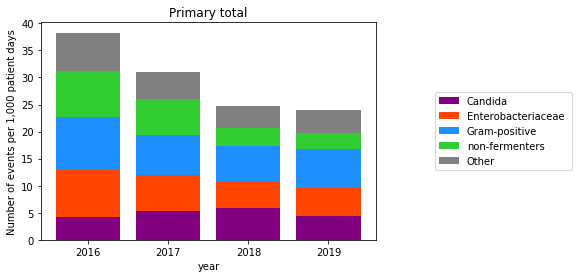

In [176]:
t=bacteria_class_grouped_pd
y1 = t['primary_total_rate'].loc[t['bacteria_class']=='Candida',].values
y2 = t['primary_total_rate'].loc[t['bacteria_class']=='Enterobacteriaceae\xa0',].values
y3 = t['primary_total_rate'].loc[t['bacteria_class']=='Gram-positive',].values
y4 = t['primary_total_rate'].loc[t['bacteria_class']=='non-fermenters',].values
y5 = t['primary_total_rate'].loc[pd.isnull(t['bacteria_class']),].values

x=['2016','2017','2018','2019']

plt.bar(x,y1,color="purple",label='Candida')
plt.bar(x,y2,bottom=y1,color="orangered",label='Enterobacteriaceae\xa0')
plt.bar(x,y3,bottom=y1+y2,color="dodgerblue",label='Gram-positive')
plt.bar(x,y4,bottom=y1+y2+y3,color="limegreen",label='non-fermenters')
plt.bar(x,y5,bottom=y1+y2+y3+y4,color="gray",label='Other')

plt.xlabel('year')
plt.ylabel('Number of events per 1,000 patient days') 
plt.legend(loc='center right', bbox_to_anchor=(1.6, 0.5))
plt.title('Primary total')
plt.savefig('bacteria_plot_1.png',pad_inches=0.5)

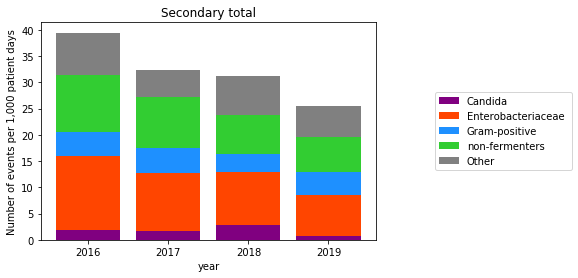

In [177]:
t=bacteria_class_grouped_pd
y1 = t['secondary_BSI_rate'].loc[t['bacteria_class']=='Candida',].values
y2 = t['secondary_BSI_rate'].loc[t['bacteria_class']=='Enterobacteriaceae\xa0',].values
y3 = t['secondary_BSI_rate'].loc[t['bacteria_class']=='Gram-positive',].values
y4 = t['secondary_BSI_rate'].loc[t['bacteria_class']=='non-fermenters',].values
y5 = t['secondary_BSI_rate'].loc[pd.isnull(t['bacteria_class']),].values

x=['2016','2017','2018','2019']

plt.bar(x,y1,color="purple",label='Candida')
plt.bar(x,y2,bottom=y1,color="orangered",label='Enterobacteriaceae\xa0')
plt.bar(x,y3,bottom=y1+y2,color="dodgerblue",label='Gram-positive')
plt.bar(x,y4,bottom=y1+y2+y3,color="limegreen",label='non-fermenters')
plt.bar(x,y5,bottom=y1+y2+y3+y4,color="gray",label='Other')

plt.xlabel('year')
plt.ylabel('Number of events per 1,000 patient days') 
plt.legend(loc='center right', bbox_to_anchor=(1.6, 0.5))
plt.title('Secondary total')
plt.savefig('bacteria_plot_1.png',pad_inches=0.5)

In [180]:
#writer = pd.ExcelWriter(r'results_8_7.xlsx', engine='xlsxwriter')
#bacteria_final.to_excel(writer, sheet_name='bacteria')
#writer.save()

#writer = pd.ExcelWriter(r'bacteria_class_by_year.xlsx', engine='xlsxwriter')
#bacteria_class_grouped_pd.to_excel(writer, sheet_name='sheet_1')
#writer.save()

In [187]:
writer = pd.ExcelWriter(r'results_24_5_22.xlsx', engine='xlsxwriter')
table_4_Ward_IRD.to_excel(writer, sheet_name='ward+IRD')
#table_4_size.to_excel(writer, sheet_name='HospGroup')
#secondary_by_year.to_excel(writer, sheet_name='secondary')
bacteria_group_grouped_pd.to_excel(writer, sheet_name='bacteria')
bacteria_class_grouped_pd.to_excel(writer, sheet_name='bacteria_group')
    #worksheet_1 = writer.sheets['bacteria']
    #worksheet_1.insert_image('E3','bacteria_plot_1.png')
hosp_analysis.to_excel(writer,sheet_name='Intervention_by_hosp')
hosp_analysis_total.to_excel(writer,sheet_name='Intervention_total')
bacteria_class_period.to_excel(writer,sheet_name='bacteria_by_period')

writer.save()